### Classical Base Model: MNIST Data

Here, we experiment with a model with basic CNN layers and classical contrastive pair loss to make the model predict whether 2 images belong to the same class or different class.

We will make pairs of images, if they belong to the same class the label will be set to 1, otherwise 0. The model's goal will be to predict the label correctly.

We will consider only images of 0 and 1 from MNIST dataset, as the datasets we will use later on are also binary (electron-photon or quark-gluon)

In [1]:
# Required Imports
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import confusion_matrix as cmatrix
from tensorflow.keras import layers, models, losses, optimizers
import pandas as pd
import itertools
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

In [2]:
tf.random.set_seed(42)

### Data Loading and Pre-processing

In [3]:
data = np.load('../../data/quark_gluon_dataset_1/qg_20000_views_c4.npz', allow_pickle=True)

In [4]:
pairs = data["pairs"]
labels = data["labels"]
del data

In [5]:
0 in labels

True

In [6]:
from sklearn.model_selection import train_test_split
pairs_train, pairs_test, labels_train, labels_test = train_test_split(pairs, labels, test_size=0.33, random_state=42)
print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape,labels_test.shape)

(13400, 2, 125, 125, 4) (6600, 2, 125, 125, 4)
(13400,) (6600,)


In [7]:
del pairs, labels

In [8]:
pairs_train = pairs_train[:,:,:,:,3]
pairs_test = pairs_test[:,:,:,:,3]
print(pairs_train.shape, pairs_test.shape)

(13400, 2, 125, 125) (6600, 2, 125, 125)


In [9]:
pairs_train = np.expand_dims(pairs_train, -1)
pairs_test = np.expand_dims(pairs_test, -1)
print(pairs_train.shape, pairs_test.shape)

(13400, 2, 125, 125, 1) (6600, 2, 125, 125, 1)


### Defining the Model

In [10]:
def plot_sample_pairs(pairs, labels, num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(pairs[i, 0].reshape(125, 125), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(pairs[i, 1].reshape(125, 125), cmap='gray')
        ax.axis('off')

        label = labels[i]
        plt.title(f'Sample: {i}, Label: {label}')

    plt.tight_layout()
    plt.show()

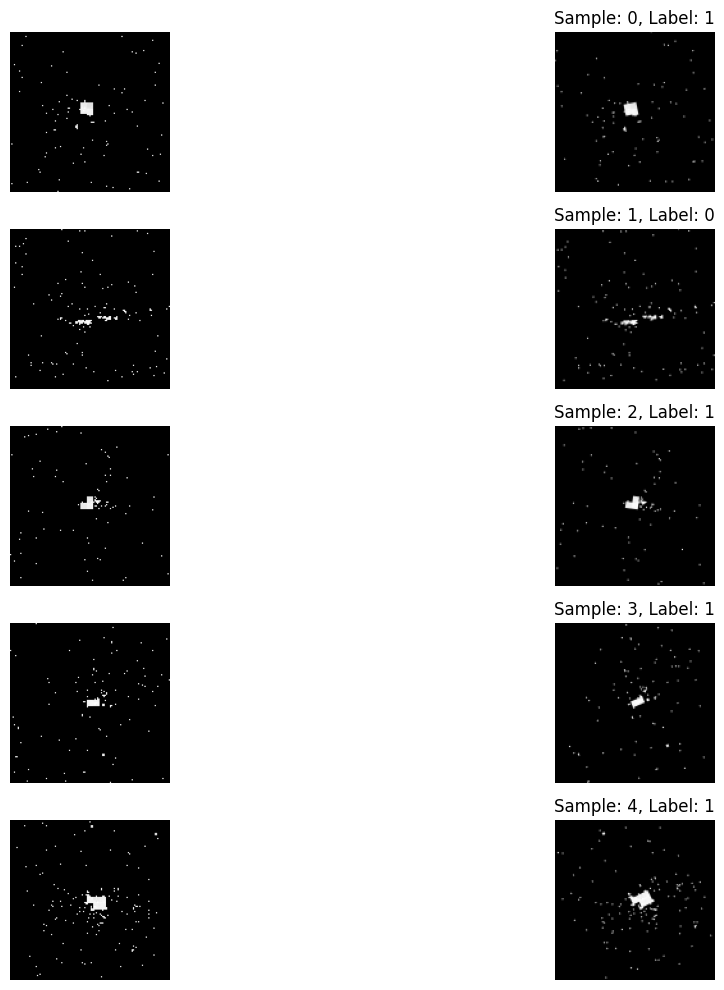

In [11]:
plot_sample_pairs(pairs_train, labels_train)

In [12]:
0 in labels_train

True

## Contrastive Pair Loss

The contrastive pair loss is used to learn representations by contrasting positive and negative pairs of samples. 

The formula is given by:

$$
L = \frac{1}{2N} \sum_{i=1}^{N} \left[ y_i \cdot d_i^2 + (1 - y_i) \cdot \max(margin - d_i, 0)^2 \right]
$$

where:

- **L** is the contrastive loss
- **N** is the number of pairs
- **$y_i$** is a binary label indicating whether the pair ($x_i$, $x_j$) is a positive pair (1) or a negative pair (0)
- **$d_i$** is the distance between the embeddings of the pair ($x_i$, $x_j$)
- **margin** is a predefined margin

In this formula:

- For positive pairs $y_i$ = 1, the loss encourages the distance $d_i$ to be small
- For negative pairs $y_i$ = 0, the loss encourages the distance $d_i$ to be larger than the margin

This helps in clustering positive pairs together and pushing negative pairs apart when creating their embeddings


In [13]:
# Contrastive loss function based on margin
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

def training_accuracy():
    def accuracy(y_true, distance, threshold=0.5):
        y_pred_binary = tf.cast(distance <= threshold, tf.int32)
        true_positives = tf.reduce_sum(tf.cast((y_true == 1) & (y_pred_binary == 1), tf.float32))
        true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred_binary == 0), tf.float32))
        accuracy = (true_positives + true_negatives) / tf.cast(tf.size(y_true), tf.float32)
        return accuracy
    return accuracy

In [14]:
# Define the CNN model 
def create_base_model(input_shape, return_embeddings=False):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    # model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    if return_embeddings:
        return model
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

# model.add(layers.Conv2D(32, (3, 3)))
#     model.add(layers.BatchNormalization())  # Adding Batch Normalization
#     model.add(layers.Activation('relu'))    # Adding Activation
#     model.add(layers.MaxPooling2D((2, 2)))  # Adding MaxPooling
#     model.add(layers.Dropout(0.3))  

## Siamese Networks 
Siamese networks are neural architectures used for similarity learning. They are particularly useful for tasks like image similarity estimation, where we want to determine the similarity or dissimilarity between two input samples.

They consist of two identical subnetworks (twins or branches) that share the same weights. Each subnetwork takes an input sample (e.g., an image) and produces an embedding vector (a compact representation) for that input. In our case, **create_base_model** is the subnetwork. The embedding vectors are then compared to assess the similarity between the two input samples.

The goal of contrastive learning is to optimize the network’s parameters so that similar inputs have embeddings that are closer together in the feature space, while dissimilar inputs are pushed further apart. In the context of Siamese networks, we use a contrastive loss function to achieve this, defined and explained above.

Reiterating about the Contrastive Loss Function:
- The contrastive loss encourages the network to learn embeddings such that:
-- For similar pairs, the distance (e.g., Euclidean distance) between their embeddings is minimized.
-- For dissimilar pairs, the distance between their embeddings is maximized.
- The margin parameter controls how far apart the embeddings of dissimilar pairs should be.
- The loss function penalizes the network when it fails to satisfy these conditions.

In the training process, this network is fed pairs of input samples along with their corresponding labels: similar (1) or dissimilar (0), The network learns to produce embeddings that align with the desired similarity/dissimilarity constraints using the custom defined loss function.

In [15]:
# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape, return_embeddings=True)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])
    
    siamese_model = models.Model([input_0, input_1], distance)
    
    return siamese_model, base_model

In [16]:
import wandb
from wandb.integration.keras import WandbMetricsLogger,WandbModelCheckpoint
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [17]:
run = wandb.init(
    project = "ML4Sci-QuantumContrastiveLearning",
    config = {
        "dataset":"QG-channel-4-125by125",
        "model":"Base Classical CNN",
        "loss":"contrastive pair loss"
    }
)
# Define the model
input_shape = pairs_train.shape[2:]
siamese_network, base_model = create_siamese_network(input_shape)

# Compile the model
siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam(),metrics=[training_accuracy()])

# Train the model
history = siamese_network.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=10,
    batch_size=1000,
    callbacks = [WandbMetricsLogger(log_freq=10),WandbModelCheckpoint(filepath="models/")]
)


Epoch 1/10


14/14 [==============================] - ETA: 0s - loss: 1.2960 - accuracy: 0.4986  INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 4.5s


14/14 [==============================] - 1577s 115s/step - loss: 1.2960 - accuracy: 0.4986 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4960 INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 3.8s


14/14 [==============================] - 685s 49s/step - loss: 0.5029 - accuracy: 0.4960 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4987 INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 3.9s


14/14 [==============================] - 705s 52s/step - loss: 0.5029 - accuracy: 0.4987 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 4/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4971 INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 3.5s


14/14 [==============================] - 654s 48s/step - loss: 0.5029 - accuracy: 0.4971 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 5/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4973 INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 3.8s


14/14 [==============================] - 651s 48s/step - loss: 0.5029 - accuracy: 0.4973 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 6/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4974 INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 3.8s


14/14 [==============================] - 762s 55s/step - loss: 0.5029 - accuracy: 0.4974 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 7/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4958 INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 3.4s


14/14 [==============================] - 733s 53s/step - loss: 0.5029 - accuracy: 0.4958 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 8/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4969 INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 4.9s


14/14 [==============================] - 719s 53s/step - loss: 0.5029 - accuracy: 0.4969 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 9/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4966  INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 7.7s


14/14 [==============================] - 1244s 91s/step - loss: 0.5029 - accuracy: 0.4966 - val_loss: 0.4971 - val_accuracy: 0.5038
Epoch 10/10
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.4988  INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 12.7s


14/14 [==============================] - 1656s 118s/step - loss: 0.5029 - accuracy: 0.4988 - val_loss: 0.4971 - val_accuracy: 0.5038


In [18]:
# wandb.log({"model_summary":siamese_network.summary()})
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 125, 125, 1)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 125, 125, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64)                   6196908   ['input_2[0][0]',             
                                                          8          'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None,)                      0         ['sequential[0][0]',      

In [19]:
learning_df = pd.DataFrame(history.history)

<Axes: title={'center': 'Learning History Error'}>

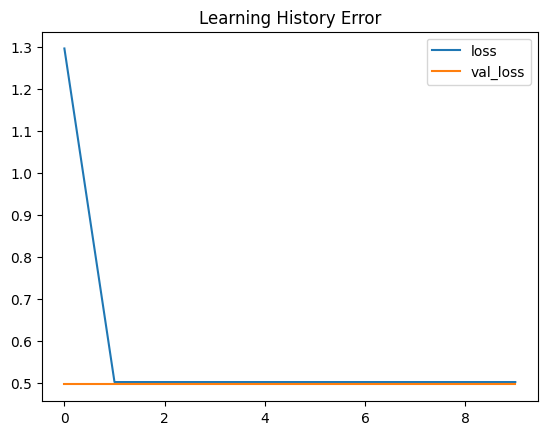

In [20]:
learning_df[["loss","val_loss"]].plot(title="Learning History Error")

<Axes: title={'center': 'Learning History Accuracy'}>

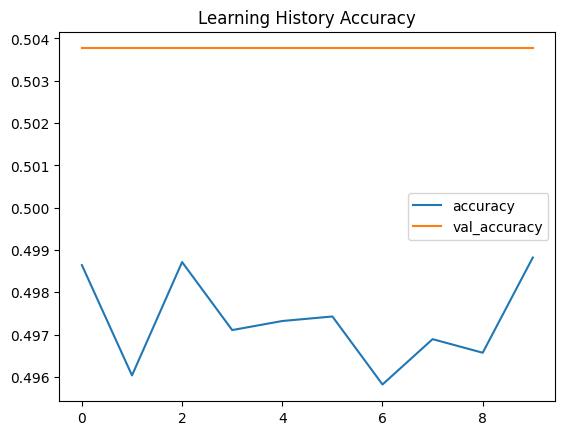

In [21]:
learning_df[["accuracy","val_accuracy"]].plot(title="Learning History Accuracy")

In [ ]:
# wandb.log({"loss": list(learning_df["loss"]), "val_loss":list(learning_df["val_loss"]), 
#            "accuracy":list(learning_df["accuracy"]), "val_accuracy":list(learning_df["val_accuracy"])})

## Evaluation

### Evaluation of the model

In [22]:
def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

In [23]:
# Predictions from the model
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])
y_pred = distances_to_labels(distance)

207/207 [==============================] - 148s 696ms/step


In [24]:
def plot_samples_with_predictions(test_pairs, test_labels, predictions, distances, num_samples=5):
    fig = plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        # ax = plt.subplot(num_samples, 2, 2 * i + 1)
        ax = fig.add_subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(test_pairs[i, 0].reshape(125, 125), cmap='gray')
        ax.axis('off')

        ax = fig.add_subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(test_pairs[i, 1].reshape(125, 125), cmap='gray')
        ax.axis('off')

        label = test_labels[i]
        pred = predictions[i]
        dist = distances[i]
        ax.set_title(f'True: {label}, Pred: {pred}, Dist: {dist:0.15f}')

    wandb.log({"plot_samples_predictions": wandb.Image(fig)})
    plt.tight_layout()
    plt.show()

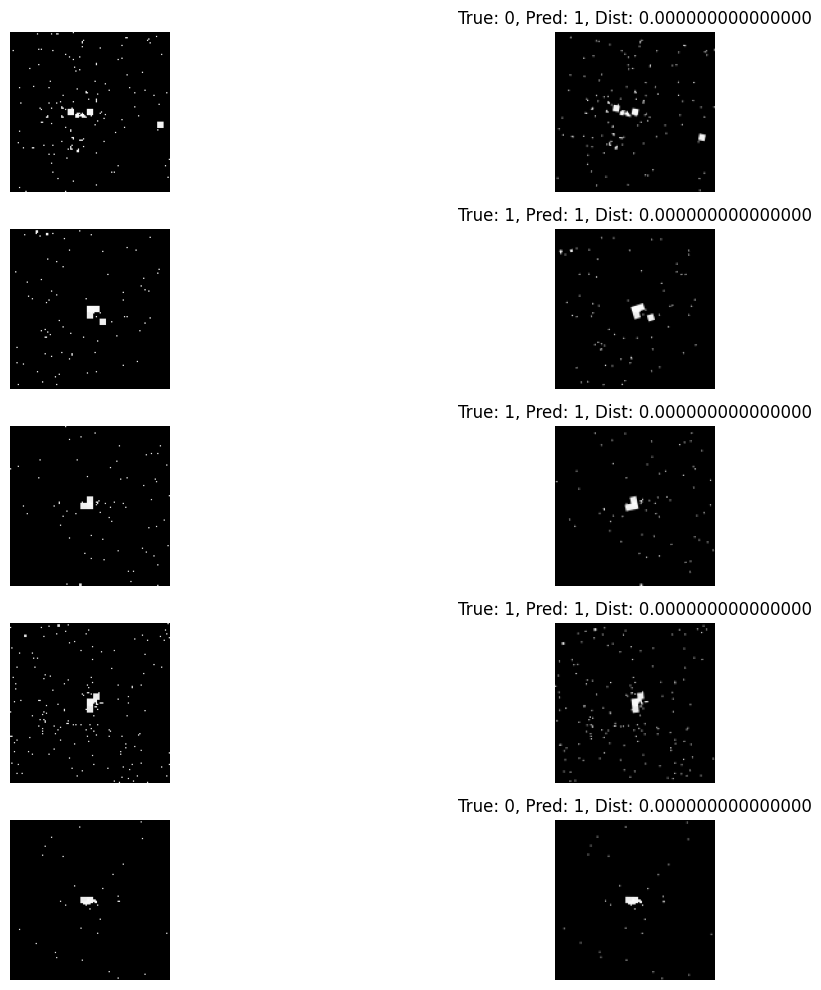

In [25]:
# Plot sample pairs with predictions
plot_samples_with_predictions(pairs_test, labels_test, y_pred, distance, num_samples=5)

### Precision, Recall, Accuracy

In [32]:
def evaluate_precision_recall_accuracy(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))
    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))
    
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    accuracy = (true_positives + true_negatives) / len(y_true)
    
    return precision, recall, accuracy

In [33]:
wandb.log({"precision_recall_accuracy":evaluate_precision_recall_accuracy(labels_test,y_pred)})

In [38]:
wandb.finish()

batch/accuracy,▂▅▂▅▅▄▁▄▆▄▆▄▆▅▃▄█▅▃▄
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▁█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch/accuracy,█▁█▄▄▅▁▃▃█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.49427
